# Sea surface temperature Canary

Plot the SST in the Canary Current Upwelling System.

In [3]:
import sys
sys.path.insert(0, '..')
import os
import glob
from filament import filament
import datetime
import netCDF4
import cmocean
import logging
import numpy as np
import matplotlib.pyplot as plt
from importlib import reload
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.mpl.ticker as cartopyticker
myproj = ccrs.PlateCarree()
coast = cfeature.GSHHSFeature(scale="f")
reload(filament)
plt.style.use("filament.mplstyle")

In [4]:
logger = logging.getLogger("filamentPlot")
logger.setLevel(logging.INFO)
logging.info("Starting")
plotvis = 0

In [5]:
datadir = "/media/ctroupin/My Passport/data/SST/Canary/"

figdir = "../figures/SST/2023/"
visibledir = "/data/Visible/"
datafilelist = sorted(glob.glob(os.path.join(datadir, "SNPP_VIIRS.202304*.nc")))
nfiles = len(datafilelist)
logger.info("Processing {} files".format(nfiles))
mediumdomain = (-19., -6., 25., 35.)
smalldomain = (-15., -9., 27., 33.)
tinydomain = (-12., -9., 29.5, 32.)
canarydomain = (-19., -13., 26., 30.)
medseadomain = (-2.5, 0., 36., 37.)

INFO:filamentPlot:Processing 6 files


In [6]:
if not(os.path.exists(figdir)):
    os.makedirs(figdir)

## Loop on files

INFO:filamentPlot:Working on /media/ctroupin/My Passport/data/SST/Canary/SNPP_VIIRS.20230428T032400.L2.SST3.NRT.nc
INFO:filamentPlot:Level-2 data


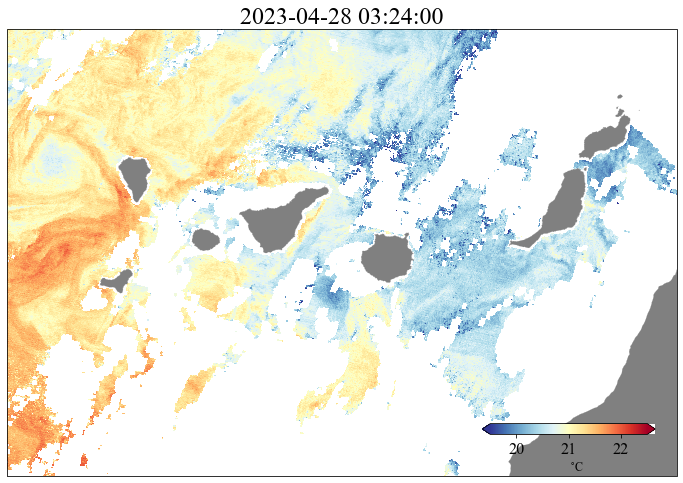

INFO:filamentPlot:Working on /media/ctroupin/My Passport/data/SST/Canary/SNPP_VIIRS.20230428T144201.L2.SST.NRT.nc
INFO:filamentPlot:Level-2 data


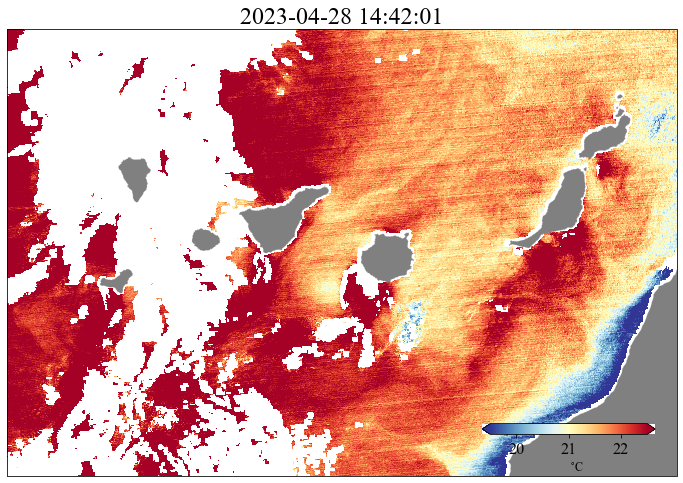

INFO:filamentPlot:Working on /media/ctroupin/My Passport/data/SST/Canary/SNPP_VIIRS.20230429T030601.L2.SST3.NRT.nc
INFO:filamentPlot:Level-2 data


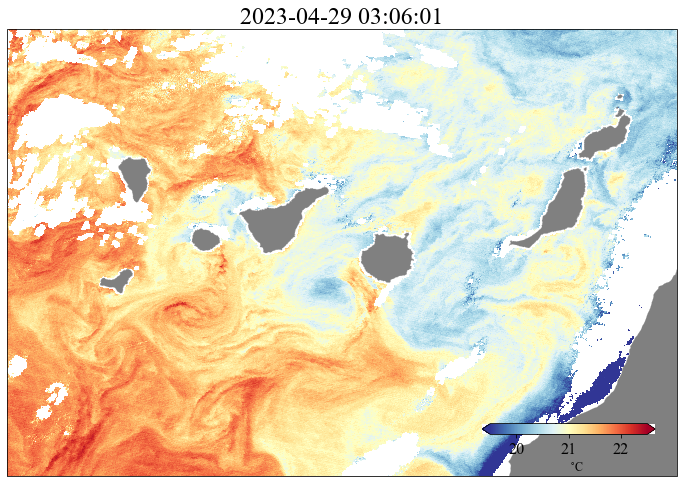

INFO:filamentPlot:Working on /media/ctroupin/My Passport/data/SST/Canary/SNPP_VIIRS.20230429T142400.L2.SST.NRT.nc
INFO:filamentPlot:Level-2 data


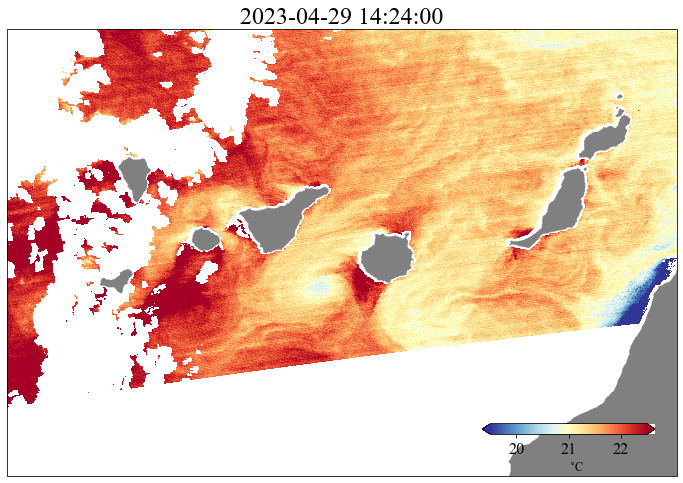

INFO:filamentPlot:Working on /media/ctroupin/My Passport/data/SST/Canary/SNPP_VIIRS.20230430T024800.L2.SST3.NRT.nc
INFO:filamentPlot:Level-2 data


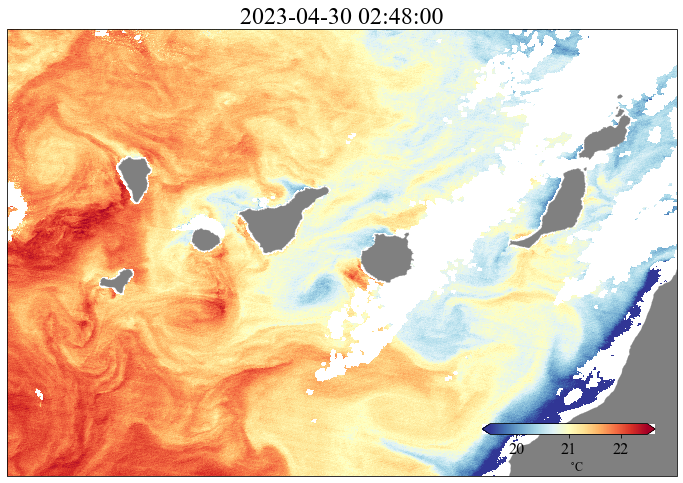

INFO:filamentPlot:Working on /media/ctroupin/My Passport/data/SST/Canary/SNPP_VIIRS.20230430T140000.L2.SST.NRT.nc
INFO:filamentPlot:Level-2 data


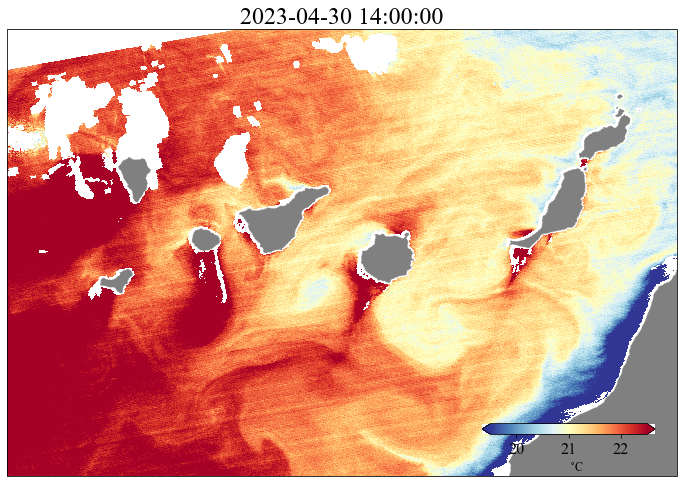

In [8]:
for ifile, datafile in enumerate(datafilelist):
    logger.info("Working on {}".format(datafile))
    
    #chloro = filament.Chloro()
    #chloro.read_from_oceancolorL2(datafile)
    
    
    with netCDF4.Dataset(datafile) as nc:
        proclevel = nc.processing_level
    sst = filament.SST()
    
    # Select the reader according to processing level
    if proclevel == "L3 Mapped":
        logger.info("Level-3 data")
        sst.read_from_oceancolorL3(datafile, coordinates)
    elif proclevel == "L2":
        logger.info("Level-2 data")
        sst.read_from_oceancolorL2(datafile)
        sst.field = np.ma.masked_where(sst.qflag > 1, sst.field)
        
    # Compute min and max values in the region of interest 
    # (to adapt the colorbar)
    #sstmin, sstmax = get_sst_limits(sst, [-18., -15., 27., 29.])
    sstmin, sstmax = 19.5, 22.5
    
    figname = os.path.join(figdir, sst.get_figname())

    fig = plt.figure(figsize=(12, 10))
    ax = plt.subplot(111, projection=myproj)
    plt.title(sst.date.strftime("%Y-%m-%d %H:%M:%S"), fontsize=24)
    
    """
    if sst.date.month <= 3:
        textplot = "Winter"
    elif sst.date.month <= 6:
        textplot = "Spring"
    elif sst.date.month <= 9:
        textplot = "Summer"
    else:
        textplot = "Fall"
    
        
    t = ax.text(0.025, 0.95, textplot, horizontalalignment='left', verticalalignment='center',
            transform = ax.transAxes, fontsize=24)
    t.set_bbox(dict(facecolor='white', alpha=0.75, edgecolor='.85'))
    
    # Add track
    
    ax.plot(tracklon, tracklat, "k-", linewidth=1.5, zorder=4, label="navigation")
    ax.plot(tracklon[1:3], tracklat[1:3], "#11DD24", linewidth=3, zorder=5, label="sampling")
    ax.plot(tracklon[3:5], tracklat[3:5], "#11DD24", linewidth=3, zorder=5)
    ax.plot(tracklon[5:7], tracklat[5:7], "#11DD24", linewidth=3, zorder=5)
    ax.plot(tracklon[7:9], tracklat[7:9], "#11DD24", linewidth=3, zorder=5)
    ax.plot(tracklon[9:11], tracklat[9:11], "#11DD24", linewidth=3, zorder=5)
    ax.plot(tracklon[11:13], tracklat[11:13], "#11DD24", linewidth=3, zorder=5)
    
    if ifile == 0:
        plt.legend(loc=1)
    
        ax.text(0.5 * (tracklon[1] + tracklon[2]), 
                0.5 * (tracklat[1] + tracklat[2]), "1", fontsize=22, ha="left")
        ax.text(0.5 * (tracklon[3] + tracklon[4]), 
                0.5 * (tracklat[3] + tracklat[4]), "2", fontsize=22, va="top")
        ax.text(0.5 * (tracklon[5] + tracklon[6]), 
                0.5 * (tracklat[5] + tracklat[6]), "3", fontsize=22, va="top", ha="right")
        ax.text(0.5 * (tracklon[7] + tracklon[8]), 
                0.5 * (tracklat[7] + tracklat[8]), "4", fontsize=22, va="top")
        ax.text(0.5 * (tracklon[7] + tracklon[8]), 
                0.5 * (tracklat[7] + tracklat[8]), "4", fontsize=22, va="top")
        ax.text(0.5 * (tracklon[9] + tracklon[10]), 
                0.5 * (tracklat[9] + tracklat[10]), "5", fontsize=22, va="top", ha="right")
        ax.text(0.5 * (tracklon[11] + tracklon[12]), 
                0.5 * (tracklat[11] + tracklat[12]), "6 ", fontsize=22, va="top", ha="right")

    """
    iii = 0
    #for tlon, tlat in zip(tracklon, tracklat):
    #    iii += 1
    #    ax.text(tlon, tlat, iii, horizontalalignment='center', verticalalignment='center',
    #        fontsize=15)
        
    #vis.add_to_plot(ax, myproj)
    #sst.field[sst.lat.data == -999.] = np.nan
    #sst.field[sst.lon.data == -999.] = nµp.nan
    #sst.lat[sst.lat.data == -999.] = np.nan
    #sst.lon[sst.lon.data == -999.] = np.nan
    
    #sst.lat = np.ma.masked_equal(sst.lat, -999.0, copy=True)
    #sst.lon = np.ma.masked_equal(sst.lon, -999.0, copy=True)
    sst.add_to_plot(fig, ax, domain=canarydomain, cmap=plt.cm.RdYlBu_r,
                    clim=[sstmin, sstmax], vis=False,
                    cbarloc=[0.675, 0.25, 0.2, 0.015], alpha=1)
    
    ax.add_feature(coast, linewidth=.2, color=".5")
    filament.decorate_map(ax, canarydomain, np.arange(-2.5, 1., 0.5), 
                              np.arange(36., 37.01, 0.25))
    plt.savefig(figname)
    plt.show()
    plt.close(fig)

In [19]:
def get_sst_limits(sst, domain=[-180., 180., -90., 90.]):
    valex = -32767.0
    
    goodlon = np.where( (sst.lon[:] <= domain[1]) & (sst.lon[:] >= domain[0]) )
    goodlat = np.where( (sst.lat[:] <= domain[3]) & (sst.lat[:] >= domain[2]) )
    goodcords = np.where( (sst.lon[:] <= domain[1]) 
                         & (sst.lon[:] >= domain[0]) 
                         & (sst.lat[:] <= domain[3]) 
                         & (sst.lat[:] >= domain[2]))
    sstdomain = sst.field[goodcords]
    goodvals = (sstdomain > 10.)
    sstmin = np.ceil(np.percentile(sstdomain[goodvals], 1.))
    sstmax = np.floor(np.percentile(sstdomain[goodvals], 99.))

    return sstmin, sstmax